# Traffic prediction model

## Abstract

This notebook explores a method of predicting traffic patterns on freeways. A naive approach to predict traffic for a particular station would be to use traffic state from all other station on a freeway. This would prove to be computatinally heavy and not feasable for a notebook. However based on this theme there are many simpler permutation of station combinations that can be fed into the model. For example; State of all stations. State of all stations in a freeway. State of all preceding stations. State of preceding staiton. State of all anteceding station. State of anteceding station. State of anteceding and precdeding station, etc.

For this model the assumtion is made that cars do appear or disapear on any segment of freeway between two stations, execpt when there are intermediate on-ramps or off-ramps between stations. With this assumption, a prediction should be possible based on the preceding stations flow and occupancy. This is the model described below. 

This method should capture the intial traffic formation. This method may not capture the observed traffic propagation. Specifically backwards traveling waves of traffic. Further refinement of the model may include adding the state of antecedingpostceding stations. 

This model consists of two submodels. The first model called the Station Traffic Model (STM) predicts traffic patterns for an individual Station Model (SM) based on the preceding station's flow, occupancy, and intermediate on ramp and off ramp flows. The second model called the Freeway Traffic Model (FTM) predicts traffic patterns for a freeway from the SMs, and previous station state. The model is intialized with initial station state. The model is used by feeding in previously predicted station state and pumping the first staiton flow and occupancy, and on-ramps and off-ramp flows.

Once traffic has been predicted use the fundumental diagram  based model get a prediction of confidence of a stations traffic state for each time step in the FTM

## Data cleanup
Must have good data for any starting section. Therefore must not start on an unhealthy station. Might also be a good idea to drop any unhealthy stations.

## Validation

### Base case
Assume all stations are always not in jam
For test data set, classify as always in jam, get percentage correct. Ballpark estimation of 80% correct.

### Data split
Random continous segments of time

## Station Models (SM)
* stations are in order of flow
* X<sub>n,t</sub>
    * X is a station flow and occupancy
    * where n is 0..N, N=number of stations
    * where t is 0..T, T=5 minute interval 
* O<sub>n-1..n,t-1</sub>
    * O is on-ramps flow
    * where n-1..n is between X<sub>n-1,t-1</sub> and X<sub>n,t-1</sub>
* F<sub>n-1..n,t-1</sub> 
    * F is off-ramps flow
    * where n-1..n is between X<sub>n-1,t-1</sub> and X<sub>n,t-1</sub>

## Station Traffic Model (STM)
#### STM<sub>n</sub>(X<sub>n-1,t-1</sub>, O<sub>n-1..n,t-1</sub>, F<sub>n-1..n,t-1</sub> ) = X'<sub>n,t</sub>
* X<sub>n-1,t-1</sub> is flow and occupancy of X<sub>n-1,t-1</sub>
* O<sub>n-1..n,t-1</sub> is flow of all OR between X<sub>n-1,t-1</sub> and X<sub>n,t</sub>
* F<sub>n-1..n,t-1</sub> is flow of all FR between X<sub>n-1,t-1</sub> and X<sub>n,t</sub>
* X'<sub>n,t</sub> is prediction of flow and occupancy for X'
    
## Freeway Traffic Model (FTM)
### Initialization at t=0 : FTM<sub>0</sub>
#### FTM<sub>0</sub>(STM<sub>1..N</sub>,  X<sub>0..N,0</sub>, O<sub>0..N,0</sub>, F<sub>0..N,0</sub>) = X'<sub>1..N,1</sub>

* X<sub>0..N,0</sub> is initial station state
* STM<sub>1..N</sub> is trained station traffic model
* O<sub>0..N,0</sub> is initial on ramp flow between stations
* F<sub>0..N,0</sub> is initial off ramp flow between stations
* X'<sub>0..N,1</sub> is predicted traffic for X<sub>0..N</sub>

### FTM at t=1..T : FTM<sub>1..T</sub>

#### FTM<sub>t</sub>(STM<sub>1..N</sub>,  X'<sub>0,p;1..N,t-1</sub>, O<sub>0..N,p</sub>, F<sub>0..N,p</sub>) = X'<sub>1..N,t</sub>
* X'<sub>1..N,t-1</sub> is previous predicted station state for station 1..0
* X'<sub>0,p</sub> is pumped station state for station 0
* STM<sub>0..N</sub> is trained station traffic model
* O<sub>0..N,p</sub> is pumped on-ramp flow between stations
* F<sub>0..N,p</sub> is pumped off-ramp flow between stations
* X'<sub>0..N,t+1</sub> is predicted traffic for X'<sub>0..N</sub>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from os import listdir
from os.path import isfile, join
from datetime import time, datetime

import glob

from pyspark.sql.functions import hour, mean,minute, stddev, count,max as psmax,min as psmin, date_format
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import lit


In [2]:
#data locations
data_5min_path = "../data/station_5min/2015/d11/"
meta_path = "../data/station_5min/2015/meta_data/d11/"

# Get data file names

In [3]:
#get all files to process
onlyfiles = [f for f in listdir(data_5min_path) if isfile(join(data_5min_path, f))]

In [4]:
onlyfiles[0:3]

['d11_text_station_5min_2015_01_01.txt.gz',
 'd11_text_station_5min_2015_01_02.txt.gz',
 'd11_text_station_5min_2015_01_03.txt.gz']

In [5]:
colnames = [
    'Timestamp','Station','District','Freeway','Direction_of_Travel',
    'LaneType','StationLength','Samples',
    'Perc_Observed','TotalFlow','AvgOccupancy','AvgSpeed',
    'Lane1_Samples','Lane1_Flow','Lane1_AvgOcc','Lane1_AvgSpeed','Lane1_Observed',
    'Lane2_Samples','Lane2_Flow','Lane2_AvgOcc','Lane2_AvgSpeed','Lane2_Observed',
    'Lane3_Samples','Lane3_Flow','Lane3_AvgOcc','Lane3_AvgSpeed','Lane3_Observed',
    'Lane4_Samples','Lane4_Flow','Lane4_AvgOcc','Lane4_AvgSpeed','Lane4_Observed',
    'Lane5_Samples','Lane5_Flow','Lane5_AvgOcc','Lane5_AvgSpeed','Lane5_Observed',
    'Lane6_Samples','Lane6_Flow','Lane6_AvgOcc','Lane6_AvgSpeed','Lane6_Observed',
    'Lane7_Samples','Lane7_Flow','Lane7_AvgOcc','Lane7_AvgSpeed','Lane7_Observed',
    'Lane8_Samples','Lane8_Flow','Lane8_AvgOcc','Lane8_AvgSpeed','Lane8_Observed'
]
colnames = [c.lower() for c in colnames]

In [6]:
len(colnames)

52

In [7]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

# Make spark schema

struct list was generated with the following code after reading the files with inferschema = true, then hand modified 
```
'[' + ','.join(['StructField("%s",%s(),True)'% (colnames[idx], str(i.dataType))
for idx, i in enumerate(rdd.schema)]) + ']'
```

In [8]:
#print '[\n    ' + ",\n    ".join(['StructField("%s",%s(),True)'% (colnames[idx], str(i.dataType))
#for idx, i in enumerate(rdd.schema)]) + '\n]'

# Build dataframe with spark

In [9]:
struct_list = [
    StructField("timestamp",TimestampType(),True),
    StructField("station",IntegerType(),True),
    StructField("district",IntegerType(),True),
    StructField("freeway",IntegerType(),True),
    StructField("direction_of_travel",StringType(),True),
    StructField("lanetype",StringType(),True),
    StructField("stationlength",DoubleType(),True),
    StructField("samples",IntegerType(),True),
    StructField("perc_observed",IntegerType(),True),
    StructField("totalflow",IntegerType(),True),
    StructField("avgoccupancy",DoubleType(),True),
    StructField("avgspeed",DoubleType(),True),
    StructField("lane1_samples",IntegerType(),True),
    StructField("lane1_flow",IntegerType(),True),
    StructField("lane1_avgocc",DoubleType(),True),
    StructField("lane1_avgspeed",DoubleType(),True),
    StructField("lane1_observed",IntegerType(),True),
    StructField("lane2_samples",IntegerType(),True),
    StructField("lane2_flow",IntegerType(),True),
    StructField("lane2_avgocc",DoubleType(),True),
    StructField("lane2_avgspeed",DoubleType(),True),
    StructField("lane2_observed",IntegerType(),True),
    StructField("lane3_samples",IntegerType(),True),
    StructField("lane3_flow",IntegerType(),True),
    StructField("lane3_avgocc",DoubleType(),True),
    StructField("lane3_avgspeed",DoubleType(),True),
    StructField("lane3_observed",IntegerType(),True),
    StructField("lane4_samples",IntegerType(),True),
    StructField("lane4_flow",IntegerType(),True),
    StructField("lane4_avgocc",DoubleType(),True),
    StructField("lane4_avgspeed",DoubleType(),True),
    StructField("lane4_observed",IntegerType(),True),
    StructField("lane5_samples",IntegerType(),True),
    StructField("lane5_flow",IntegerType(),True),
    StructField("lane5_avgocc",DoubleType(),True),
    StructField("lane5_avgspeed",DoubleType(),True),
    StructField("lane5_observed",IntegerType(),True),
    StructField("lane6_samples",IntegerType(),True),
    StructField("lane6_flow",IntegerType(),True),
    StructField("lane6_avgocc",DoubleType(),True),
    StructField("lane6_avgspeed",DoubleType(),True),
    StructField("lane6_observed",IntegerType(),True),
    StructField("lane7_samples",IntegerType(),True),
    StructField("lane7_flow",IntegerType(),True),
    StructField("lane7_avgocc",DoubleType(),True),
    StructField("lane7_avgspeed",DoubleType(),True),
    StructField("lane7_observed",IntegerType(),True),
    StructField("lane8_samples",IntegerType(),True),
    StructField("lane8_flow",IntegerType(),True),
    StructField("lane8_avgocc",DoubleType(),True),
    StructField("lane8_avgspeed",DoubleType(),True),
    StructField("lane8_observed",IntegerType(),True)
]

schema_struct = StructType(struct_list)

In [10]:
#node this is only the first 5 days of files for now
files = [data_5min_path + filename for filename in onlyfiles[:3]]

rdd = spark.read.csv(
    files, 
    header='false',
    timestampFormat='MM/dd/yyyy HH:mm:ss',
    schema=schema_struct,
    inferSchema='false'
)
    
rdd.take(1)

[Row(timestamp=datetime.datetime(2015, 1, 2, 0, 0), station=1100313, district=11, freeway=5, direction_of_travel=u'N', lanetype=u'FR', stationlength=None, samples=10, perc_observed=100, totalflow=8, avgoccupancy=None, avgspeed=None, lane1_samples=10, lane1_flow=8, lane1_avgocc=None, lane1_avgspeed=None, lane1_observed=1, lane2_samples=None, lane2_flow=None, lane2_avgocc=None, lane2_avgspeed=None, lane2_observed=0, lane3_samples=None, lane3_flow=None, lane3_avgocc=None, lane3_avgspeed=None, lane3_observed=0, lane4_samples=None, lane4_flow=None, lane4_avgocc=None, lane4_avgspeed=None, lane4_observed=0, lane5_samples=None, lane5_flow=None, lane5_avgocc=None, lane5_avgspeed=None, lane5_observed=0, lane6_samples=None, lane6_flow=None, lane6_avgocc=None, lane6_avgspeed=None, lane6_observed=0, lane7_samples=None, lane7_flow=None, lane7_avgocc=None, lane7_avgspeed=None, lane7_observed=0, lane8_samples=None, lane8_flow=None, lane8_avgocc=None, lane8_avgspeed=None, lane8_observed=0)]

In [11]:
rdd.count()

1277856

# Get metadata and identify all FR OR and their preceding and antceding station

In [12]:
def loadMeta():
    meta_dir='../data/External/meta/2015/d11/d11_text_meta_2015_*.txt'
    meta_files = glob.glob(meta_dir)

    meta_file_list = []
    for meta_file in meta_files:
        date = str('_'.join(meta_file.split('_')[4:7])).split('.')[0]
        df = pd.read_table(meta_file, index_col=None, header=0)
        date_col = pd.Series([date] * len(df))
        df['file_date'] = date_col
        # drop rows that are missing latitude / longitude values
        #df.dropna(inplace=True, subset=['Latitude', 'Longitude'], how='any')
        meta_file_list.append(df)

    meta_frame = pd.concat(meta_file_list).drop_duplicates(subset='ID', keep='last')

    usefwy = [ 56, 125, 805,  52, 163,   8,  15,   5, 905,  78,  94,  54]

    meta_frame = meta_frame[meta_frame.Fwy.apply(lambda x: x in usefwy)]

    #Add freeway name FwyDir
    meta_frame['freeway'] = meta_frame.Fwy.apply(str) + meta_frame.Dir
    
    r_c = {}
    for c in meta_frame.columns:
        r_c[c]=c.lower()
    
    meta_frame=meta_frame.rename(columns = r_c )
    return meta_frame

loadMeta().head(1)

,id,fwy,dir,district,county,city,state_pm,abs_pm,latitude,longitude,length,type,lanes,name,user_id_1,user_id_2,user_id_3,user_id_4,file_date,freeway
584,1113072,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,0.452,ML,2,Black Mountain Rd,314,NaN,NaN,NaN,01_01,56W


# Get time min time for time delta

In [13]:
station_stats = (
    rdd
    .agg(
        psmax("timestamp").alias("timestamp_max"),
        psmin("timestamp").alias("timestamp_min")
    )
    .toPandas()
)
station_stats.timestamp_min.values[0]

numpy.datetime64('2015-01-01T00:00:00.000000000')

In [91]:
union_rdd_list[0].take(1)

[Row(station=1121740, timestamp=datetime.datetime(2015, 1, 3, 23, 55), totalflow=160, avgoccupancy=0.027, avgspeed=72.9, delta=863, dtime=863, fwy=5, dir=u'S', abs_pm=72.008, length=0.757, type=u'ML', lanes=5, block=0, locat=1, group=0)]

# Builds the meta data for station order and group construction

In [14]:
slice_df = loadMeta().loc[:,['id','fwy','dir','abs_pm','length','type','lanes']]#,'latitude','longitude']]

#slice_df['url'] = slice_df.apply(lambda x:'http://maps.google.com/maps?&z=15&q=%s+%s'%(x.latitude, x.longitude),axis=1)
slice_df = slice_df[slice_df.apply(lambda x: 5 is x.fwy and 'S' in x.dir, axis=1)]
slice_df.sort_values('abs_pm', inplace = True, ascending=False)

#slice_df['block'] = slice_df.type.apply(lambda x:x in ['ML']).astype(int).cumsum()
slice_df['block'] = slice_df.type.shift(1).apply(lambda x:x in ['ML']).astype(int).cumsum()
slice_df = slice_df.reset_index(drop=True)
segments = slice_df.reset_index().groupby(['block'])['index'].apply(np.array)

In [105]:
dtime = udf(
    lambda x: x-1,
    IntegerType()
)

delta = udf(
    lambda date_time: int((np.datetime64(date_time)-station_stats.timestamp_min.values[0])/np.timedelta64(5,'m')),
    IntegerType()
)

fwy_rdd = (
    rdd
    .where('freeway = 5')
    .where('direction_of_travel = "S"')
    .select('timestamp', 'station', 'totalflow', 'avgoccupancy', 'avgspeed')
    .withColumn("delta", delta(rdd.timestamp))
    .orderBy('timestamp', ascending=True)
    .cache()
)

df_slice = slice_df.rename(columns={'id':'station'})

union_rdd_list = []

for idx,(p,s,a) in enumerate([segments[i:i + 3] for i in range(0, len(segments)-2, 1)]):
    print idx, p, s, a, df_slice.loc[p,'station'].unique(),df_slice.loc[s,'station'].unique(),df_slice.loc[a,'station'].unique()
    
    slice_pre = sqlCtx.createDataFrame(df_slice.loc[p,:]).withColumn("locat", lit(1)).withColumn("group", lit(idx))
    slice_ant = sqlCtx.createDataFrame(df_slice.loc[a,:]).withColumn("locat", lit(2)).withColumn("group", lit(idx)) 
    slice_sta = sqlCtx.createDataFrame(df_slice.loc[s,:]).withColumn("locat", lit(0)).withColumn("group", lit(idx))
        
    pre_rdd = (
        fwy_rdd.withColumn("dtime", fwy_rdd.delta)
        .join(slice_pre, 'station')
    )

    ant_rdd = (
        fwy_rdd.withColumn("dtime", fwy_rdd.delta)
        .join(slice_ant, 'station')
    )

    sta_rdd = (
        fwy_rdd.withColumn("dtime", dtime(fwy_rdd.delta))
        .join(slice_sta, 'station')
    )

    u_rdd = (
        sta_rdd
        .union(ant_rdd)
        .union(pre_rdd)
    )
    
    union_rdd_list.append(u_rdd)

0 [0] [1] [2] [1121740] [1121734] [1121728]
1 [1] [2] [3] [1121734] [1121728] [1121722]
2 [2] [3] [4] [1121728] [1121722] [1121715]
3 [3] [4] [5] [1121722] [1121715] [1121712]
4 [4] [5] [6] [1121715] [1121712] [1121702]
5 [5] [6] [7] [1121712] [1121702] [1119997]
6 [6] [7] [8] [1121702] [1119997] [1119978]
7 [7] [8] [9] [1119997] [1119978] [1119966]
8 [8] [9] [10] [1119978] [1119966] [1119954]
9 [9] [10] [11] [1119966] [1119954] [1122257]
10 [10] [11] [12 13 14] [1119954] [1122257] [1122250 1122252 1115348]
11 [11] [12 13 14] [15 16 17] [1122257] [1122250 1122252 1115348] [1108674 1113776 1108672]
12 [12 13 14] [15 16 17] [18 19] [1122250 1122252 1115348] [1108674 1113776 1108672] [1108673 1108459]
13 [15 16 17] [18 19] [20 21 22 23] [1108674 1113776 1108672] [1108673 1108459] [1113780 1108460 1108462 1108461]
14 [18 19] [20 21 22 23] [24 25] [1108673 1108459] [1113780 1108460 1108462 1108461] [1113782 1108463]
15 [20 21 22 23] [24 25] [26 27 28 29 30] [1113780 1108460 1108462 1108461]

In [106]:
union_rdd = reduce(lambda x,y:x.union(y),union_rdd_list[:9])
df = union_rdd.toPandas()

In [131]:
df[(df.group == 8) & (df.dtime == 6)]

,station,timestamp,totalflow,avgoccupancy,avgspeed,delta,dtime,fwy,dir,abs_pm,length,type,lanes,block,locat,group
20743,1119966,2015-01-01 00:35:00,58,0.0106,69.6,7,6,5,S,55.858,1.000,ML,4,9,0,8
21606,1119954,2015-01-01 00:30:00,33,0.0062,69.9,6,6,5,S,54.858,0.783,ML,4,10,2,8
22470,1119978,2015-01-01 00:30:00,42,0.0079,69.5,6,6,5,S,56.858,1.235,ML,4,8,1,8


In [92]:
df.set_index(['group']).loc[2:].set_index(['block','locat','dtime']).loc[2,:].loc[2,:]

,station,timestamp,totalflow,avgoccupancy,avgspeed,delta,fwy,dir,abs_pm,length,type,lanes
dtime,,,,,,,,,,,,


In [47]:
df = df.sort_values(['group','dtime','abs_pm','block','locat'],ascending=[True,True,False,True,True])

In [48]:
#clean head and tail of df
df[df.group.apply(lambda x:x > 0 and x < 9) & df.dtime.apply(lambda x:x > 0) ].set_index(['dtime'])

,station,timestamp,totalflow,avgoccupancy,avgspeed,delta,fwy,dir,abs_pm,length,type,lanes,block,locat,group
dtime,,,,,,,,,,,,,,,
1,1121734,2015-01-01 00:00:00,39,0.0085,69.5,0,5,S,70.878,2.621,ML,4,1,0,1
1,1121734,2015-01-01 00:05:00,32,0.0070,68.8,1,5,S,70.878,2.621,ML,4,1,1,1
1,1121722,2015-01-01 00:05:00,32,0.0057,69.5,1,5,S,65.449,1.415,ML,4,3,2,1
2,1121734,2015-01-01 00:05:00,32,0.0070,68.8,1,5,S,70.878,2.621,ML,4,1,0,1
2,1121734,2015-01-01 00:10:00,50,0.0111,67.7,2,5,S,70.878,2.621,ML,4,1,1,1
2,1121722,2015-01-01 00:10:00,10,0.0019,67.7,2,5,S,65.449,1.415,ML,4,3,2,1
3,1121734,2015-01-01 00:10:00,50,0.0111,67.7,2,5,S,70.878,2.621,ML,4,1,0,1
3,1121734,2015-01-01 00:15:00,52,0.0114,68.8,3,5,S,70.878,2.621,ML,4,1,1,1
3,1121722,2015-01-01 00:15:00,74,0.0150,66.6,3,5,S,65.449,1.415,ML,4,3,2,1


In [178]:
#day = udf(lambda date_time: date_time.day, IntegerType())
#/np.timedelta64(5,'m')
#-
#print type(station_stats.timestamp_min.values[0])
#day = udf(lambda date_time: int((np.datetime64(date_time)-station_stats.timestamp_min.values[0])/np.timedelta64(5,'m')))
#df.withColumn("day", day(df.date_time))
#rdd.withColumn("delta", day(rdd.timestamp)).take(1)

# Find a station segment to test

In [15]:
slice_df = loadMeta().loc[:,['id','fwy','dir','abs_pm','length','type','lanes']]
slice_df = slice_df[slice_df.apply(lambda x: 5 is x.fwy and 'S' in x.dir, axis=1)]
slice_df.sort_values('abs_pm',inplace = True)


#loc=14
loc=37

slice_of_heaven = sqlCtx.createDataFrame(slice_df.iloc[loc:loc+3,:].rename(columns={'id':'station'}))

In [ ]:
slice_of_heaven.show()

In [16]:
df = (
    rdd
    .where('freeway = 5')
    .where('direction_of_travel = "S"')
    .select('timestamp','station','totalflow','avgoccupancy','avgspeed')
    .join(slice_of_heaven, 'station')
    .toPandas()
)

df['delta'] = (df.timestamp-df.timestamp.min()).apply(lambda x: int(x/np.timedelta64(5,'m')))
df = df.sort_values(['delta','abs_pm']).set_index(['delta'])

In [17]:
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model

from sklearn.metrics import mean_squared_error

import seaborn as sns

In [18]:
t=1
max_t = df.index.max()


features = [
    'totalflow',
    'avgoccupancy',
#    'avgspeed',
#    'length',
#   'type',
#    'lanes'
]

y_features = [
    'totalflow',
    'avgoccupancy',
#    'avgspeed',
#    'length',
#   'type',
#    'lanes'
]

X=[]
Y=[]
for i in xrange(t,max_t/2,1):
    try:
        y = df.loc[i,y_features].iloc[1].values
        x=[]
        for j in range(1,t+1):
            x += list(df.loc[i-j,features].iloc[[0,2]].values)

        x = np.concatenate(x)

        X+=[x]
        Y+=[y]
    except:
        print 'baddata',
    
    
        
X_train=np.array(X)
Y_train=np.array(Y)

baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata


In [19]:
X=[]
Y=[]
for i in xrange(max_t/2,max_t,1):
    try:
        y = df.loc[i,y_features].iloc[1].values
        x=[]
        for j in range(1,t+1):
            x += list(df.loc[i-j,features].iloc[[0,2]].values)

        x = np.concatenate(x)

        X+=[x]
        Y+=[y]
    except:
        print 'baddata',
    
    
        
X_test=np.array(X)
Y_test=np.array(Y)

baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata baddata 

In [20]:
print X_test.shape, Y_test.shape, X_train.shape, Y_train.shape

(12794, 4) (12794, 2) (12860, 4) (12860, 2)


# Train and find MSE

In [21]:
reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
Y_pred =  reg.predict(X_train)
print list(np.sqrt(mean_squared_error(Y_train,Y_pred,multioutput='raw_values')))

Y_pred =  reg.predict(X_test)
print list(np.sqrt(mean_squared_error(Y_test,Y_pred,multioutput='raw_values')))

print reg.coef_

[24.231633130880528, 0.015647825764066408]
[24.077749180465922, 0.016184880464033279]
[[  1.97024469e-01   3.80072599e+01   5.04193684e-01   1.28498239e+02]
 [ -1.96667040e-04   1.62458083e-01   2.62922721e-04   2.43521890e-01]]


In [22]:
clf = KernelRidge(alpha=1.0)
clf.fit(X_train, Y_train)
Y_pred =  clf.predict(X_train)
print list(np.sqrt(mean_squared_error(Y_train,Y_pred,multioutput='raw_values')))

Y_pred =  clf.predict(X_test)
print list(np.sqrt(mean_squared_error(Y_test,Y_pred,multioutput='raw_values')))

[24.233380110317434, 0.015657781923902294]
[24.094811018140863, 0.01625892257884225]


In [23]:
list(np.max(Y_test,axis=0))

[432.0, 0.43369999999999997]

In [24]:
list(np.min(Y_test,axis=0))

[0.0, 0.0]

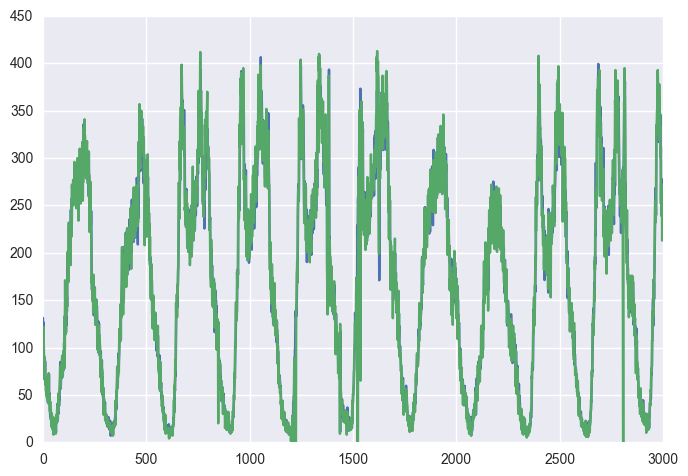

In [45]:
plt.plot(Y_pred[:3000,0])
plt.plot(Y_test[:3000,0])

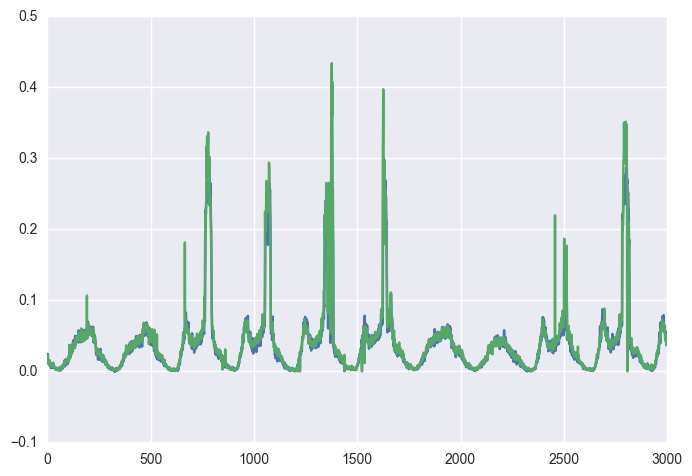

In [54]:
plt.plot(Y_pred[:3000,1])
plt.plot(Y_test[:3000,1])

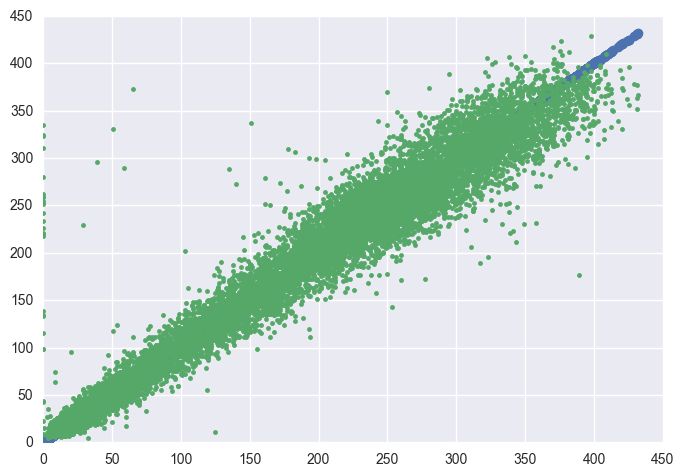

In [27]:
plt.plot(Y_test[:,0],Y_test[:,0],'o')
plt.plot(Y_test[:,0],Y_pred[:,0],'.')

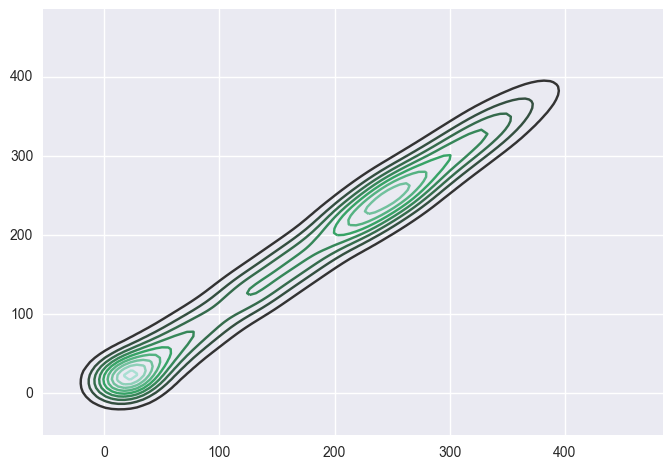

In [28]:
sns.kdeplot(Y_test[:,0],Y_test[:,0])

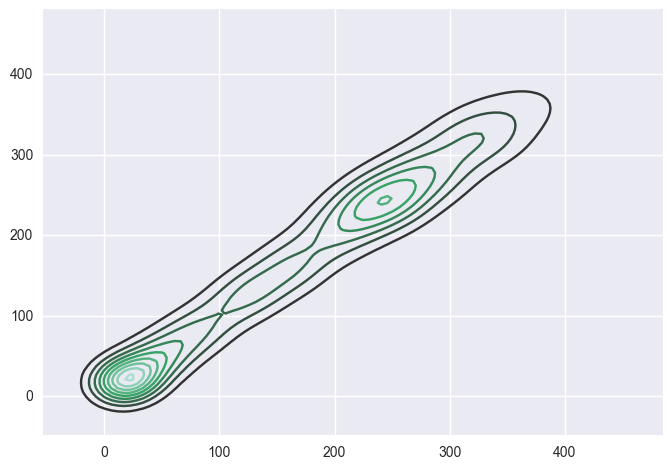

In [29]:
sns.kdeplot(Y_test[:,0],Y_pred[:,0])

In [30]:
X_test.shape

(12794, 4)

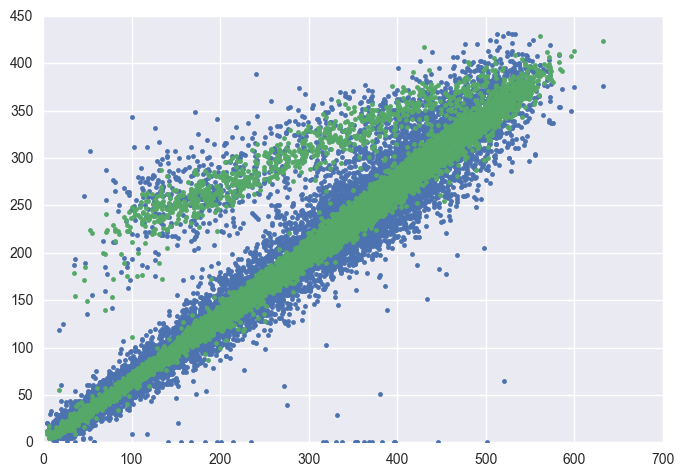

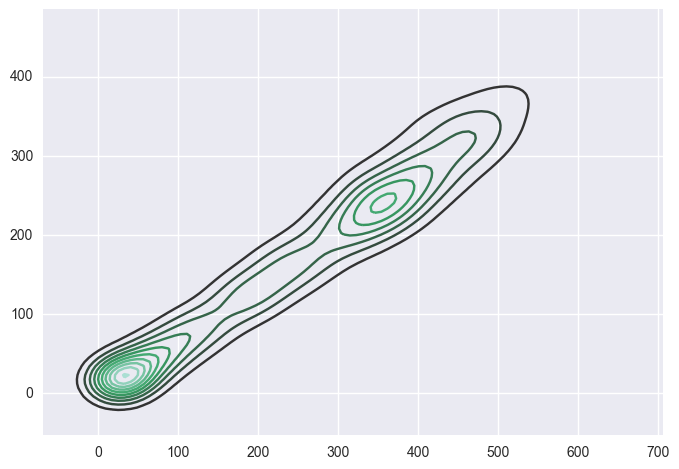

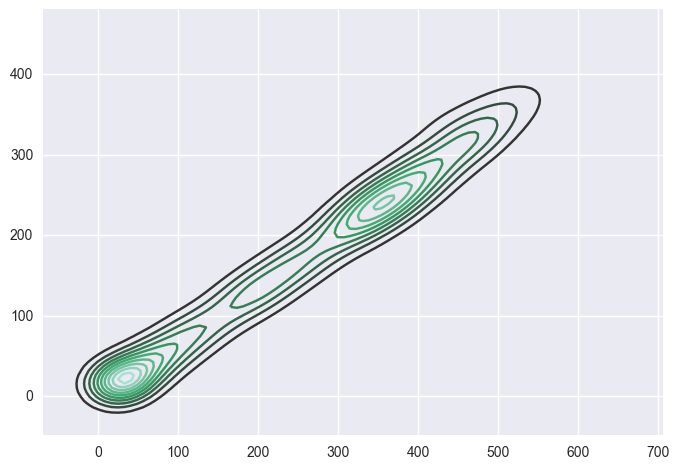

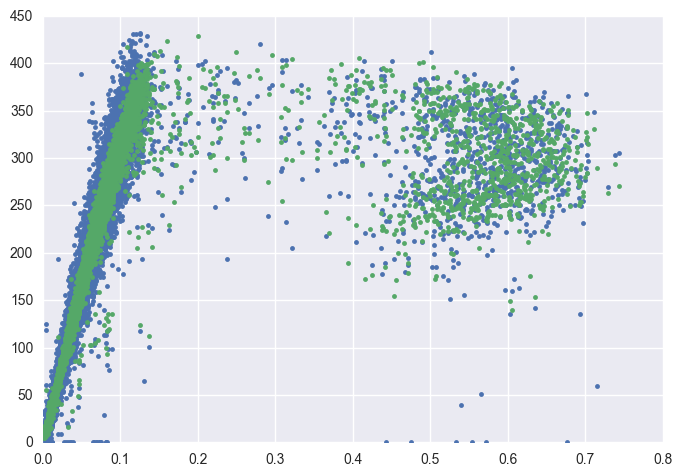

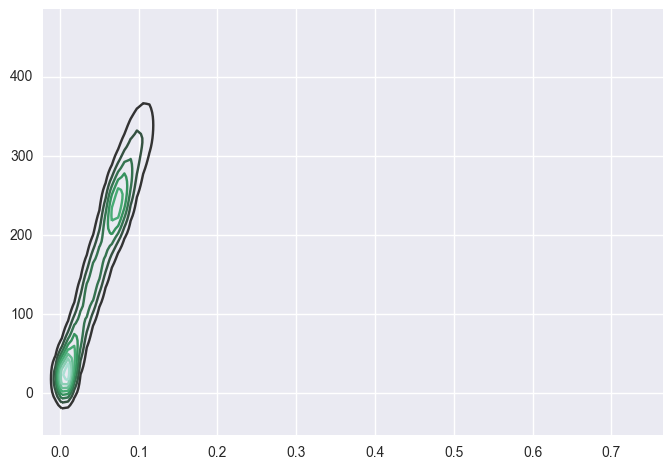

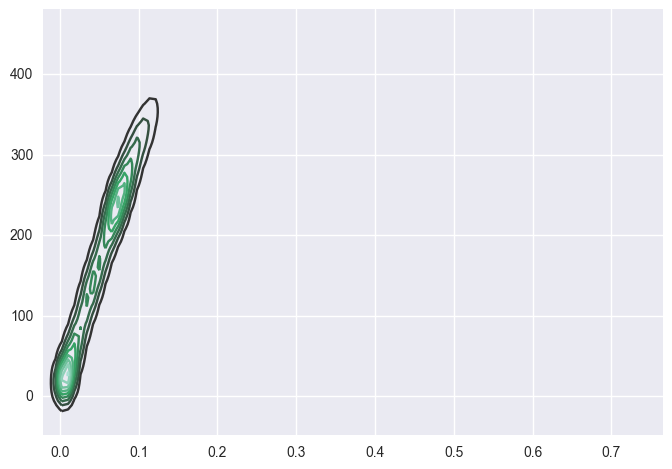

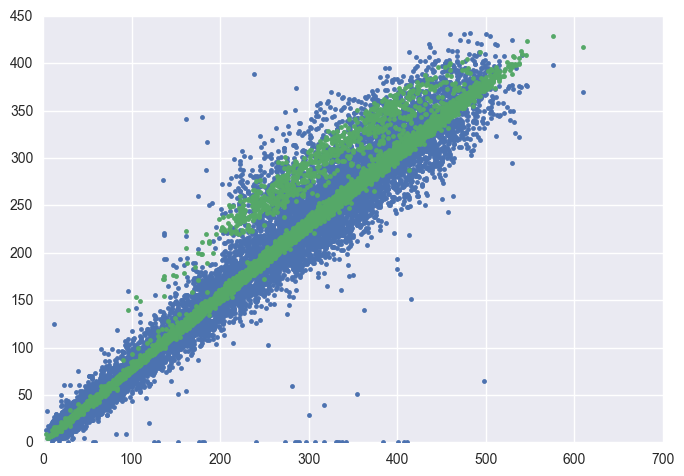

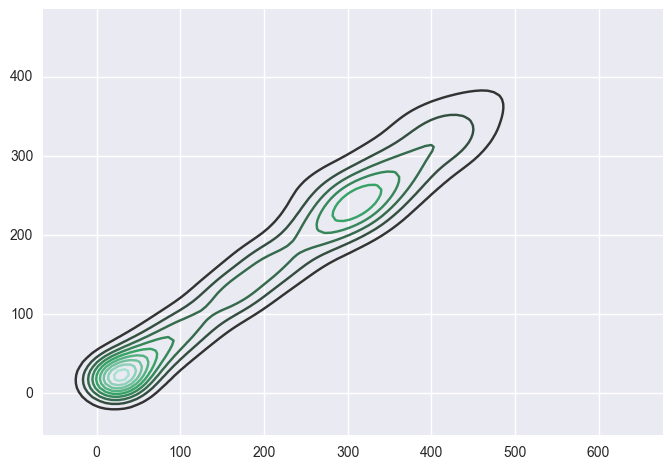

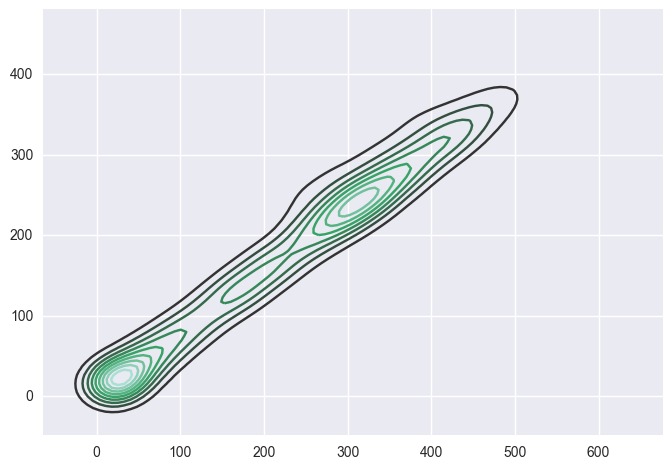

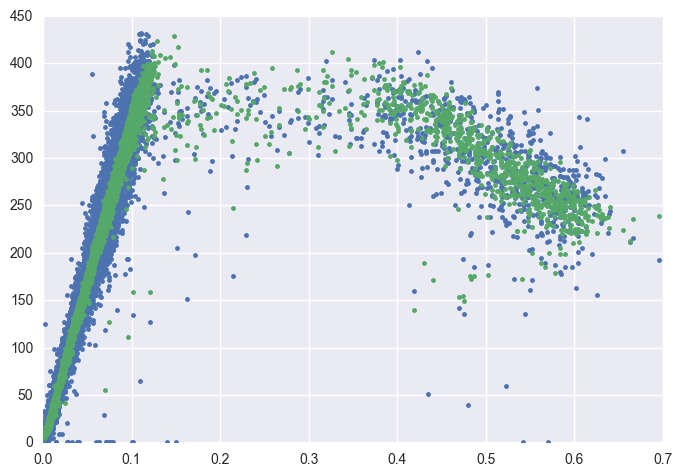

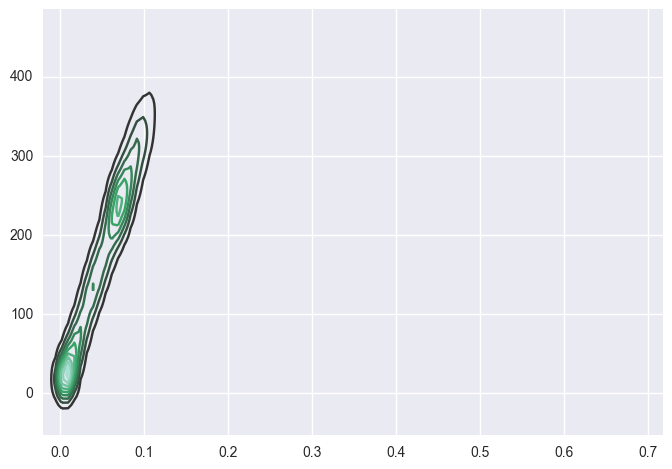

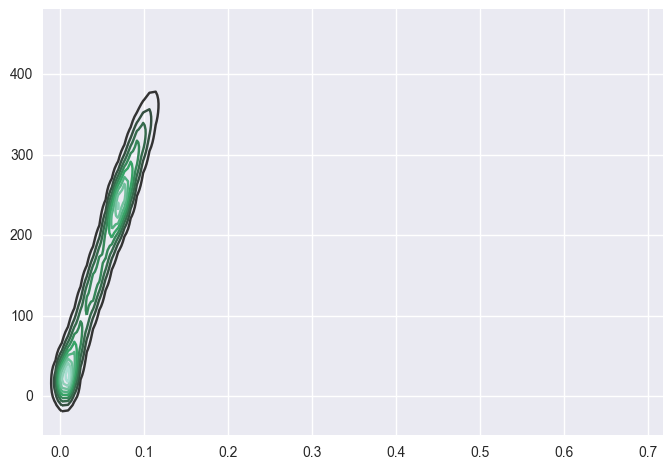

In [35]:
#for flow
for i in range(0, X_test.shape[1], 1):
    plt.figure()
    plt.plot(X_test[:,i],Y_test[:,0],'.')
    plt.plot(X_test[:,i],Y_pred[:,0],'.')
    plt.plot()
    
    plt.figure()
    sns.kdeplot(X_test[:,i],Y_test[:,0])
    plt.plot()
    plt.figure()
    sns.kdeplot(X_test[:,i],Y_pred[:,0])
    plt.plot()

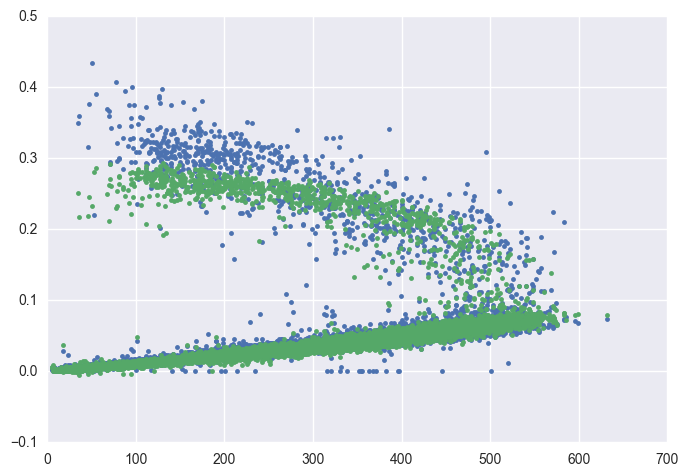

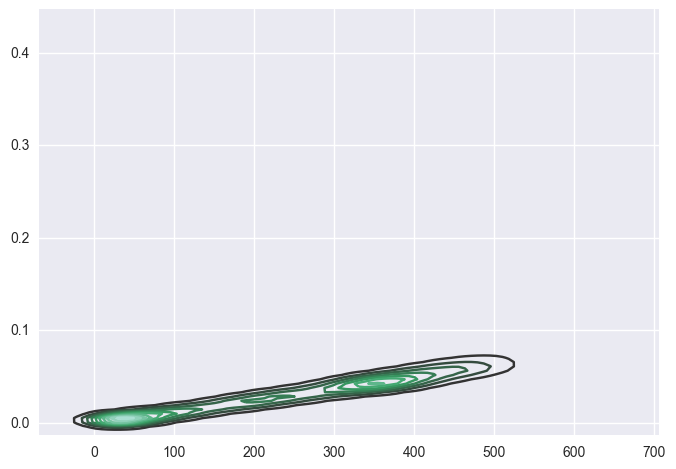

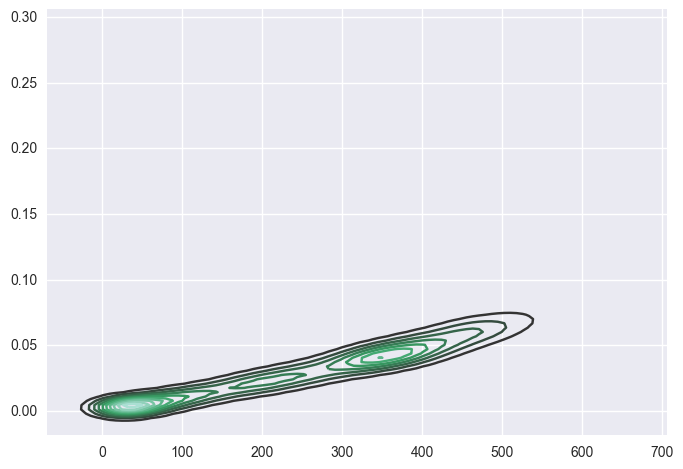

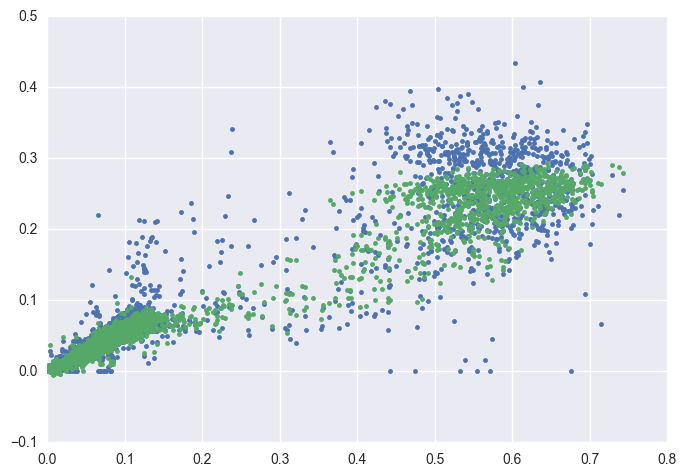

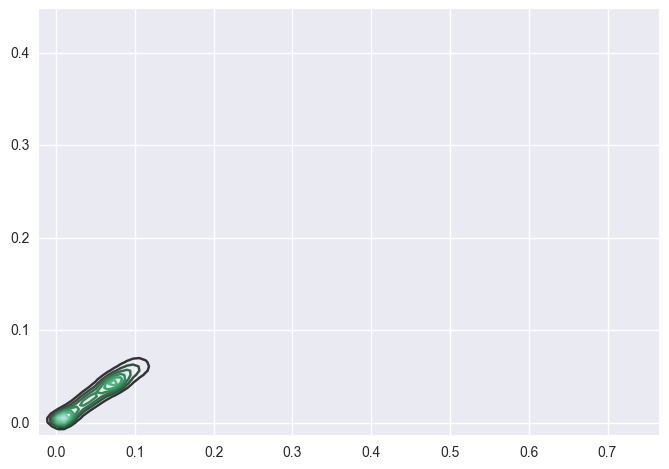

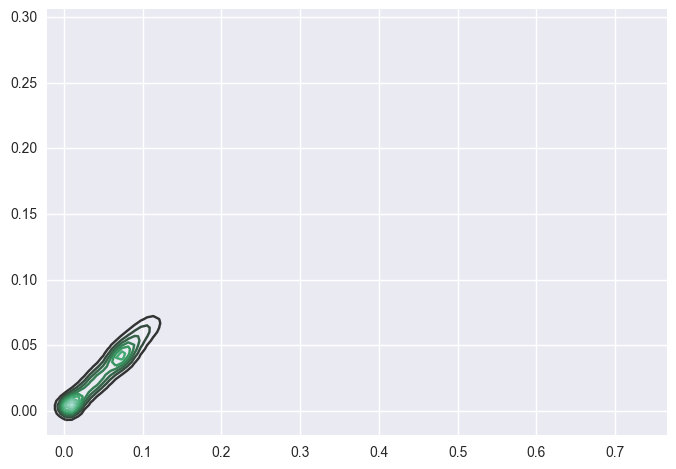

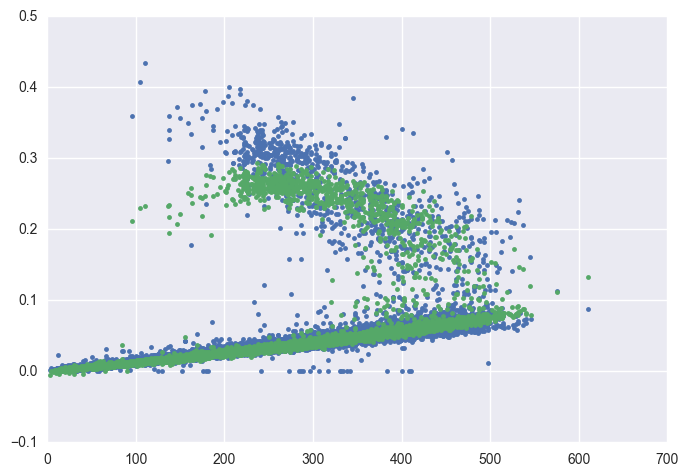

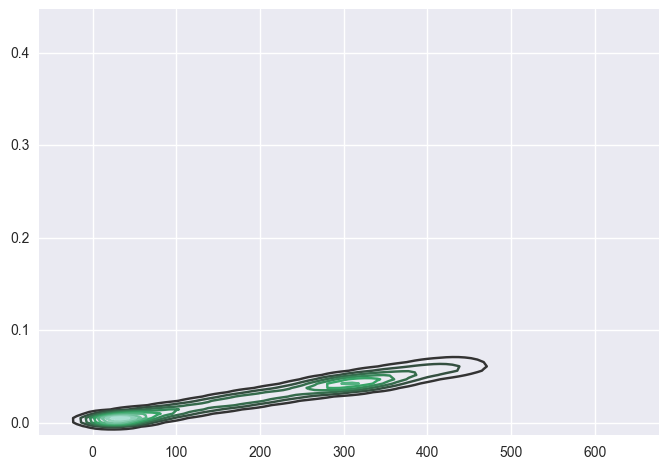

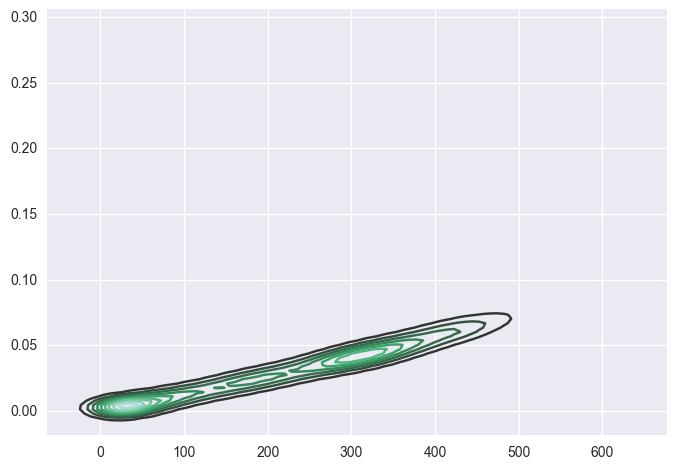

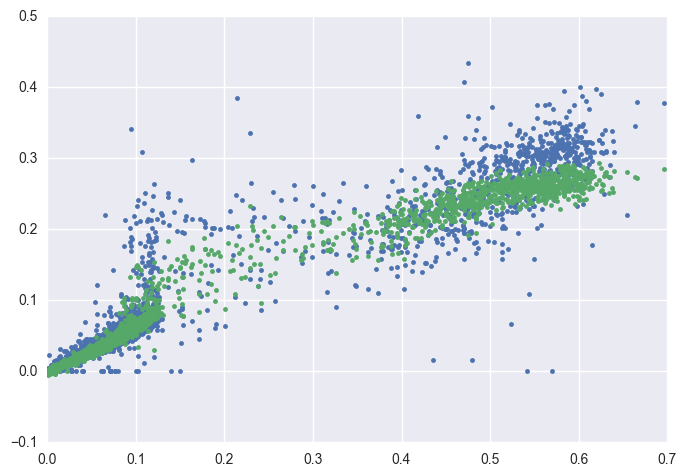

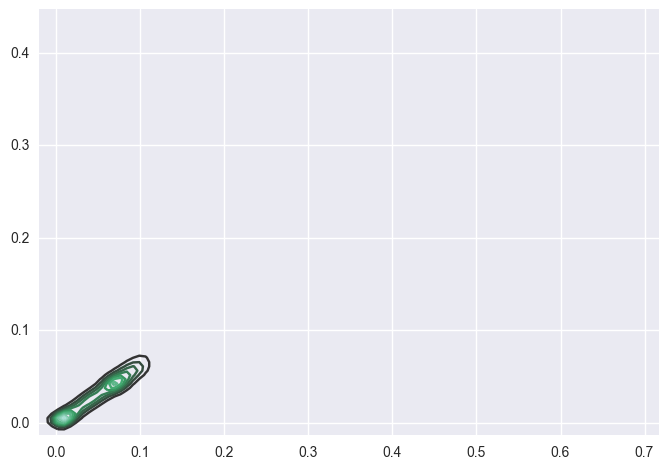

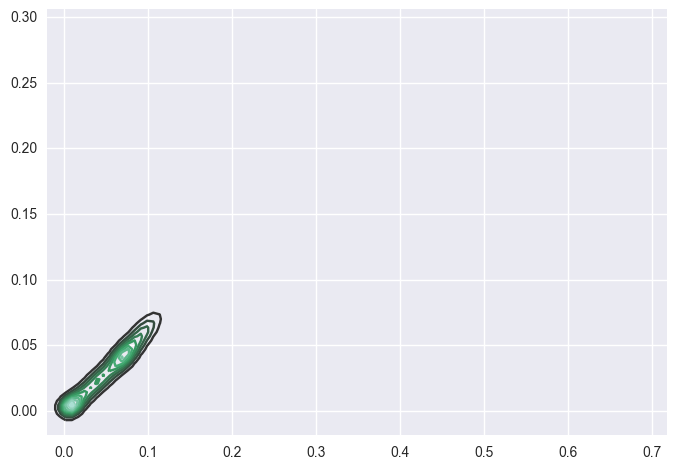

In [36]:
#for occupancy
for i in range(0, X_test.shape[1], 1):
    plt.figure()
    plt.plot(X_test[:,i],Y_test[:,1],'.')
    plt.plot(X_test[:,i],Y_pred[:,1],'.')
    plt.plot()
    plt.figure()
    sns.kdeplot(X_test[:,i],Y_test[:,1])
    plt.plot()
    plt.figure()
    sns.kdeplot(X_test[:,i],Y_pred[:,1])
    plt.plot()